In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from preprocess import process
from torch.utils import data
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 1e-2, 5, 256
train_features, test_features, train_labels, test_data = process('../data/kaggle_house_pred_train.csv', '../data/kaggle_house_pred_test.csv')
train_features, test_features, train_labels, test_data = train_features.to(device), test_features.to(device), train_labels.to(device), test_data
in_features_dim = train_features.shape[1]

loss = nn.MSELoss()

def get_net():
    net = nn.Sequential(nn.Linear(in_features_dim, 2**12),
                        nn.ReLU(),              
                        nn.Linear(2**12, 1),
                    )
    return net.to(device)

def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays) 
    return data.DataLoader(dataset, batch_size, shuffle=is_train)


def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [2]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            plt.plot(list(range(1, num_epochs + 1)), train_ls)
            plt.plot(list(range(1, num_epochs + 1)), valid_ls)
            plt.xlabel('Epoch')
            plt.ylabel('RMSE')
            plt.legend(['Train', 'Validation'])
            plt.xlim([1, num_epochs])
            plt.show()
        print(f'折{i + 1}，训练 log rmse：{float(train_ls[-1]):f}，'
              f'验证 log rmse：{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

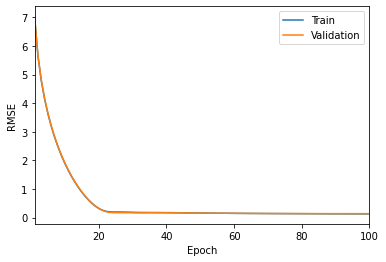

折1，训练 log rmse：0.126741，验证 log rmse：0.135792
折2，训练 log rmse：0.125356，验证 log rmse：0.145124
折3，训练 log rmse：0.119104，验证 log rmse：0.133973
折4，训练 log rmse：0.127449，验证 log rmse：0.121501
折5，训练 log rmse：0.117649，验证 log rmse：0.163701
5-折验证：平均训练 log rmse：0.123260，平均验证 log rmse: 0.140018


In [3]:
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证：平均训练 log rmse：{float(train_l):f}，'
      f'平均验证 log rmse: {float(valid_l):f}')

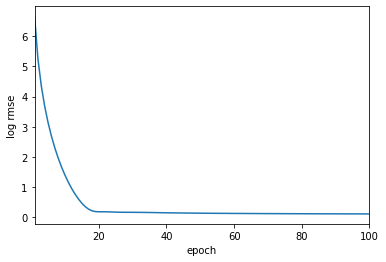

训练log rmse：0.118235


In [4]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    plt.plot([i for i in range(1, num_epochs + 1)], train_ls)
    plt.xlabel('epoch')
    plt.ylabel('log rmse')
    plt.xlim(1, num_epochs)
    # plt.yscale('log')
    plt.show()
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().cpu().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)


train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)